# "Speed-testing HuggingFace nlp Datasets vs Fastai"

> Can we get an additional text processing speedup with the nlp Datasets library?

- badges: true
- categories: [nlp, fastai, dataloader]
- image: images/sonic.png

## tl;dr
- Fastai's `Textdataloader` is well optimised and appears to be faster than `nlp Datasets` in the context of setting up your dataloaders (pre-processing, tokenizing, sorting) for a dataset of 1.6M tweets

## Speed
I started playing around with HuggingFace's [`nlp Datasets`](https://huggingface.co/nlp)  library recently and was blown away by the speed at which you can iterate through the data, thanks to some PyArrow wizardry its seriously fast!

> twitter: https://twitter.com/Thom_Wolf/status/1272512974935203841

So I wondered if there was a significant speed-up to be gained by doing as much text processing as I could with this library as opposed to Fastai's default text processing. Also, after previously discovering Fastai's functionality to do [faster text loading](https://forums.fast.ai/t/nlp-speed-up-if-using-sorteddl/74636) I was in the mood for further speed-ups! 💨


## `nlp Datasets`

The [`nlp Datasets`](https://huggingface.co/nlp) library is incredibly memory efficient; from the docs:

> It provides a very efficient way to load and process data from raw files (CSV/JSON/text) or in-memory data (python dict, pandas dataframe) with a special focus on memory efficency and speed. As a matter of example, **loading a 18GB dataset like English Wikipedia allocate 9 MB in RAM** and you can iterate over the dataset **at 1-2 GBit/s** in python.

It also hosts 130+ common nlp research datasets AND (thanks to [this pointer from Thomas Wolf](https://discuss.huggingface.co/t/nlp-0-3-0-is-out/50/3) on the new HuggingFace forums) I also learned that you can also easily load your own CSVs (or jsons, pandas dataframes) and bask in all of that speedy goodness, for example like below:

```
from nlp import load_dataset
dataset = load_dataset('csv', data_files='my_file.csv')
```

#### Caching
Another great thing about `nlp Datasets`' speed is that even if processing all of your data turns out to be slower than your current conventional processing method, the **results of its processing are cached**, which means that the second time around it will be **much faster** than your current processing method! This also applies for a new python session, i.e. if you restart your jupyter notebook!


By the way, if you're curious to learn more about PyArrow then I highly recommend Dejan Simic's [post about it](https://towardsdatascience.com/apache-arrow-read-dataframe-with-zero-memory-69634092b1a)

> twitter: https://twitter.com/simicdds/status/1276521257304023046



> Note: If you love the sound of laptop fans spinning like sonic the hedgehog 🦔, redhot battery packs 🔥 and the adrenaline 😰 of living on the edge  of pandas' capabilities as you explore, plot and manipulate your giant text datasets, then the `nlp` Datasets library probably isn't for you. 

Otherwise, regardless about using it for your final DL pipeline or not, `nlp Datasets` is definitely worth using just for the shear speed at which it can apply functions to GB's of data.

So, is it faster? Lets see! 

## The Setup

To find out we'll be comparing Fastai's high-level `TextDataloders` class to a custom dataprocessing pipeline using HuggingFace's `nlp Datasets` datasets library.

#### Fastai
This Fastai class does a bunch of different things, all by calling just 1 line of code, including:
- Pre and Post Processing
- Tokenization with Spacy's tokenizer, including creating a vocabulary and **parallelising** the tokenization
- Speed optimizations including sorting data by text sample length and padding only to the longest item in the sequence, [similar what was described here](https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e)
- Creating the train and validation dataloaders and putting them onto the GPU

#### HuggingFace `nlp Datasets`
The `nlp` Datasets pipeline I wrote tries to replicate all of the core functionality of `TextDataloaders` as best I could. 

> Note: I couldn't figure out how to parallelise the text processing with `nlp Datasets`, although this is probably down to my lack of experience with parallelism as opposed to a limitation of the library

## Sentiment Dataset
For this experiment I used the [Sentiment140](https://huggingface.co/datasets/sentiment140) dataset, a sentiment classifcation dataset of Twitter data with 1,600,000 tweets and ~120M space-separated tokens.

For our experiment we'll test with both 10% and 100% of the dataset with a 80/20 train/val split

## Experiment Settings

The timings will consist of 2 elements, an "init" and "1 epoch". The former will covering the entire process from loading the data (already downloaded) to creating the dataloaders. The second element will simply consist of iterating through the entire training dataset once.

### Init Details
The initialisation consists of:

0) Reading the data from disk, from a csv for fastai and from a PyArrow file for `nlp Datasets`
   - Note that for `nlp Datasets` a train set and a validation set were downloaded separately. Previously I had used `.select` or `.train_test_split` to generate a train and val set, however using either of these methods added over 7minutes to the pre-processing time.



1) Applying [fastai's default text pre-processing functions](http://dev.fast.ai/text.core#Preprocessing-rules). These will:


    - Fix various messy bits of html sometimes seen in documents
    - Replace repetitions at the character level, e.g. `cccc` becomes: `TK_REP 4 c`
    - Replace word repetitions, e.g. `cow cow cow cow` becomes: `TK_WREP 4 cow`
    - Add spaces around / and #
    - Remove multiple spaces 
    - Replace tokens in ALL CAPS by their lower version and add TK_UP before.
    - Replace characters in ALL CAPS by their lower version and add TK_UP before.
    - Lowercases everything
2) Tokenizing based on Spacy's tokenizer (fastai's default)

3) Applying a post-processing rule which replaces embedded spaces in a token with unicode line char to allow for split/join

4) Adding padding and sorting the samples by length for more efficient gpu usage

5) Creation of the train and validation dataloaders


## Results

#### 10% Data
Results are...mixed! While the Fastai convienience function had a faster init (48s vs 71s), the PyArrow-backed `nlp` run through a single epoch was significantly faster (11s vs 14s).

| 160K ROWS: | Init (s)| 1 epoch (s) | 1 mini-batch [bs=64] (ms) |
| :- | :-: | :-: | :-: |
| **Fastai** | 124 | 14.3 | 7.4 | 
| **Fastai w/sorted** | **48.1** | 14.3 | 7.4 |
| **nlp** | 71.2 | **11.3** | **5.6** |

#### 100% Data
For the full dataset of 1.6M tweets, Fastai dramatically outperforms `nlp Datasets`.

| 1.6M ROWS: | Init (s) | 1 epoch (s) |
| :- | :-: | :-: |
| **Fastai w/sorted** | **484** | **142** |
| **nlp**| 1034 | 323 |

## But maybe `nlp Datasets` might be faster?

Given the large difference in speed on the full dataset, I am suspicious about some parts of my implementation, specifically **sorting** the entire dataset which takes takes **416s**. Do I need to sort the full dataset? Maybe there is a smarter way to serve up a sorted dataset similar to how Fastai achieves it? Removing sorting brings `nlp Datasets` timing down to **618s**, still slower than Fastai's **484s**. Possibly with parallelism Fastai could be matched?

In addition, `nlp Datasets`'s caching means that the second time around you do your pre-processing it will be **significantly faster**.


## RAM Usage
Note that Fastai was faster on the full 1.6M row dataset, but I also had to delete the pandas dataframe used to calculate the text lengths as it was taking up too much RAM and causing my dataloaders to fail. On the other hand, `nlp Datasets` won't incur this issue as it is reading directly from disk. So even if Fastai is faster, `nlp Datasets` could still save you a few headaches when deadling with large datasets.

## To End
While not as definitive as I would like, it appears Fastai's `TextDataloaders` convenience function is faster than `nlp Datasets` for datasets of this scale for an intial setup. The question of parallelism remains. `nlp Datasets` caching will mean that if going through the same setup a second time it will be significantly faster. 

I still plan on using the `nlp Datasets` library for one-off processing and experimentation as I think it offers incredible speed and flexiblility, the team at HuggingFace have done amazing work here. 

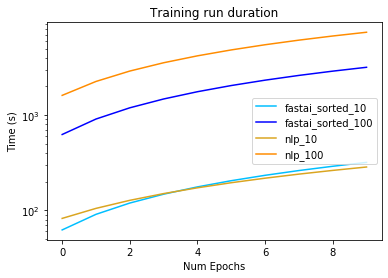

In [16]:
#hide
def get_timings(n_epochs, init, per_ep):
    #init=48
    #eps = n_epochs * 14.25
    eps = n_epochs * per_ep
    return init+eps

fastai_sorted_10 = [48, 14.25]
fastai_sorted_100 = [484, 142]
nlp_10 = [71, 11.27]
nlp_100 = [1290, 323]

timings_ls, timing_data = [], []
timings = [fastai_sorted_10,fastai_sorted_100, nlp_10, nlp_100]

n_eps = list(range(1,20,2))

for t in timings: timing_data.append([get_timings(n_epochs=n, init=t[0], per_ep=t[1]) for n in n_eps])

colors = ['deepskyblue','blue','goldenrod', 'darkorange']
labels = ['fastai_sorted_10','fastai_sorted_100','nlp_10','nlp_100']
for i,t in enumerate(timing_data):
    plt.plot(t, color=colors[i], label=labels[i])

plt.title('Training run duration')
plt.xlabel('Num Epochs')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.legend()
plt.show();

## Thanks for Reading 😃
As always, I would love to hear if you have any comments, thoughts or criticisms, you can find me on Twitter at [@mcgenergy](www.twitter.com/mcgenergy)

## [Appendix]

## Code:
For those curious, you can peek the code used in testing this below 👇

In [1]:
#collapse-hide
# Imports
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
# from fastai2.callback.all import *
# from fastai2.data.transforms import RandomSplitter
from fastai2.text.core import defaults

from nlp import load_dataset

import spacy,html
from spacy.symbols import ORTH

import timeit
import gc

### Fastai Testing
Init timing:

In [2]:
#collapse-hide
#%%timeit -n 1 -r 3

# Download data and save as csv
# senti_dataset = load_dataset('sentiment140', split='train[:100%]', download_mode='reuse_cache_if_exists')
# df = senti_dataset.data.to_pandas()
# df.to_csv('sentiment140.csv')

# Read data; the first 10% of the sentiment140 dataset, extraced from the `nlp` library and saved as a csv
#fn_10pct = 'sentiment140_10pct.csv'
fn = 'sentiment140.csv'
df = pd.read_csv(fn, index_col=None)

# SORT: Calculate text sample lengths
df['word_count'] = df['text'].str.split().map(len)

res=df['word_count'].values

# Create Dataloaders
dls = TextDataLoaders.from_csv(path='.', csv_fname=fn, valid_pct=0.2, bs=64, 
                               text_col='text', label_col='sentiment' , res=res)

1 epoch timing

In [6]:
#collapse-hide

del df, res
gc.collect()

# Do 1 pass of the training dataloader
s = """for b in dls.train: pass
    """

time = timeit.timeit(stmt=s, number=1, globals=globals()); time
time, time / len(dls.train)

(143.04122078799992, 0.007152061039399996)

### HuggingFace `nlp` Datasets Testing

Tokenizer, Numericalizer and Padding functions, modified from Fastai's functions

In [2]:
#collapse-hide
class SpacyTokenizerNLP():
    "Spacy tokenizer for `lang`"
    def __init__(self, lang='en', special_toks=None, buf_sz=5000):
        self.special_toks = ifnone(special_toks, defaults.text_spec_tok)
        nlp = spacy.blank(lang, disable=["parser", "tagger", "ner"])
        for w in self.special_toks: nlp.tokenizer.add_special_case(w, [{ORTH: w}])
        self.pipe,self.buf_sz = nlp.pipe,buf_sz
        
    def encodes(self, items):
        tmp = [list(doc) for doc in self.pipe(items, batch_size=self.buf_sz)]
        return {'tok_text_pre': [list(str(t) for t in l) for l in tmp]}

def make_vocab(count, min_freq=3, max_vocab=60000, special_toks=None):
    "Create a vocab of `max_vocab` size from `Counter` `count` with items present more than `min_freq`"
    vocab = [o for o,c in count.most_common(max_vocab) if c >= min_freq]
    special_toks = ifnone(special_toks, defaults.text_spec_tok)
    for o in reversed(special_toks): #Make sure all special tokens are in the vocab
        if o in vocab: vocab.remove(o)
        vocab.insert(0, o)
    vocab = vocab[:max_vocab]
    return vocab + [f'xxfake' for i in range(0, 8-len(vocab)%8)]

class NumericalizeNLP(Transform):
    "Reversible transform of tokenized texts to numericalized ids"
    def __init__(self, dsets=None, vocab=None, min_freq=3, max_vocab=60000, special_toks=None, pad_tok=None):
        store_attr(self, 'vocab,min_freq,max_vocab,special_toks,pad_tok')
        self.vocab, self.special_toks, self.min_freq, self.max_vocab = vocab, special_toks, min_freq, max_vocab
        self.o2i = None if vocab is None else defaultdict(int, {v:k for k,v in enumerate(vocab)})

        if self.vocab is None:
            count = Counter(p for o in dsets for p in o)
            self.vocab = make_vocab(count, min_freq=self.min_freq, max_vocab=self.max_vocab, special_toks=self.special_toks)
            self.o2i = defaultdict(int, {v:k for k,v in enumerate(self.vocab) if v != 'xxfake'})
    
    def encodes_nlp(self, o): return TensorText(tensor([self.o2i  [o_] for o_ in o]))
    def encodes_nlp(self, b): return {'toks' : [[self.o2i[o_] for o_ in oo] for oo in b['tok_text']]}
    
# Padding functions
def pad_seq(x, max_batch_len, pad_idx):    
    pad =  x.new_zeros(max_batch_len-x.size(0))+pad_idx
    return torch.cat([x, pad])
 
# Pad up to longest item in the batch and put batch on the GPU
def pad_batch(batch=None, pad_token_id=1):
    batch_inputs = list()
    max_size = max([len(item['toks']) for item in batch])
    for item in batch: batch_inputs += [pad_seq(item['toks'], max_size, pad_token_id)]
    return torch.stack(batch_inputs).cuda()

Download and define processing functions

In [9]:
#collapse-hide

# Download text, a clean version of the dataset is downloaded (not included in the timings)
train_senti_dataset = load_dataset('sentiment140', split='train[:80%]', download_mode='reuse_cache_if_exists')
val_senti_dataset = load_dataset('sentiment140', split='train[80:100%]', download_mode='reuse_cache_if_exists')

spacy_tok = SpacyTokenizerNLP(lang='en', special_toks=defaults.text_spec_tok)

def preproc_and_tok(b): return spacy_tok.encodes(list(maps(*defaults.text_proc_rules, b['text'])))

def postproc(b): 
    return {'tok_text': [list(maps(*defaults.text_postproc_rules, _b)) for _b in b['tok_text_pre']]}

def get_tok_lengths(example_batch): return {'tok_lens': [len(e) for e in example_batch['toks']]}

def prepare_dataset(dataset, vocab=None, is_train=True):
    '''
        Takes a raw nlp dataset and returns a processed, tokenized, numericalised dataset
    '''
    # Apply processing rules and tokenize
    print('pre-proc and tokenize')
    dataset = dataset.map(preproc_and_tok, batched=True)

    # Apply post-processing rules 
    print('post=proc')
    dataset = dataset.map(postproc, batched=True)

    # Init Numericalizer and create vocab
    print('init numericalizer')
    if is_train: numeric = NumericalizeNLP(dsets=dataset['tok_text_pre'], special_toks=defaults.text_spec_tok, pad_tok=1)
    else: numeric = NumericalizeNLP(dsets=dataset['tok_text_pre'], vocab=vocab,
                                    special_toks=defaults.text_spec_tok, pad_tok=1)
    
    # Numericalize
    print('numericalizing')
    dataset = dataset.map(numeric.encodes_nlp, batched=True)

    # Get sample lengths for sorting
    dataset=dataset.map(get_tok_lengths, batched=True)
    
    print('sorting')
    # Sort dataset from small to large
    dataset = dataset.sort('tok_lens')
    
    return dataset, numeric

Dataset sentiment140 downloaded and prepared to /home/morgan/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0. Subsequent calls will reuse this data.


Init Timing

In [ ]:
#collapse-hide

s = """
# Load train and validation datasets from downloaded files
train_senti_dataset = load_dataset('sentiment140', split='train[:80%]')
val_senti_dataset = load_dataset('sentiment140', split='train[80%:100%]')

# Get processed tokens
train_senti, numeric = prepare_dataset(train_senti_dataset)
val_senti, numeric = prepare_dataset(val_senti_dataset, vocab=numeric.vocab)

# Set as Pytorch type
print('setting format')
columns = ['toks','sentiment']
train_senti.set_format(type='torch', columns=columns)
val_senti[0].set_format(type='torch', columns=columns)

# Instantiate out PyTorch Dataloaders 
print('init dataloaders')
train_dataloader = torch.utils.data.DataLoader(train_senti, batch_size=64, collate_fn=pad_batch)
val_dataloader = torch.utils.data.DataLoader(val_senti, batch_size=64, collate_fn=pad_batch)
"""

time = timeit.timeit(stmt=s, number=1, globals=globals())
time

Time `nlp` 1 epoch

In [11]:
#collapse-hide
s = "for b in train_dataloader: pass"
time = timeit.timeit(stmt=s, number=1, globals=globals()); time
time, time / (len(train_senti)/64)

(323.86245587099984, 0.01619312279354999)